In [1]:
%%capture
!pipenv install pandas numpy matplotlib seaborn ipykernel transformers torch scikit-learn
!pipenv shell

Installing pandas...

Installing numpy...
Installing matplotlib...
Installing seaborn...
Installing dependencies from Pipfile.lock (6e2922)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.



[    ] Installing..
[=   ] Installing pandas..
[==  ] Installing pandas..
[=== ] Installing pandas..
[ ===] Installing pandas..
[  ==] Installing pandas..
[   =] Installing pandas..
[    ] Installing pandas..
[   =] Installing pandas..
[  ==] Installing pandas..
[ ===] Installing pandas..
[====] Installing pandas..
[=== ] Installing pandas..
[==  ] Installing pandas..
[=   ] Installing pandas..
[    ] Installing pandas..
[=   ] Installing pandas..
[==  ] Installing pandas..
[=== ] Installing pandas..
[ ===] Installing pandas..
[  ==] Installing pandas..
[   =] Installing pandas..
[    ] Installing pandas..
[   =] Installing pandas..
[  ==] Installing pandas..
[ ===] Installing pandas..
[====] Installing pandas..
[=== ] Installing pandas..
[==  ] Installing pandas..
[=   ] Installing pandas..
[    ] Installing pandas..
[=   ] Installing pandas..
[==  ] Installing pandas..
[=== ] Installing pandas..
[ ===] Installing pandas..
[  ==] Installing pandas..
[   =] Installing pandas..
[    ] 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from transformers import AutoConfig, AutoTokenizer, AutoModel

from sklearn.decomposition import PCA

c:\Users\Jeremias Ferrao\.virtualenvs\experimental-DjMT5kgn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Load data/train_text.txt
# Each line represents a different tweet

with open('data/train_text.txt', encoding='utf-8') as f:
    tweets = f.readlines()

# Get tweets from test_text.txt and val_text.txt
with open('data/test_text.txt', encoding='utf-8') as f:
    tweets += f.readlines()

with open('data/val_text.txt', encoding='utf-8') as f:
    tweets += f.readlines()

# Pandas dataframe
tweets_df = pd.DataFrame(tweets, columns=['tweet'])
tweets_df.head()

,tweet
0,Sunday afternoon walking through Venice in the...
1,Time for some BBQ and whiskey libations. Chomp...
2,Love love love all these people ️ ️ ️ #friends...
3,"️ ️ ️ ️ @ Toys""R""Us \n"
4,Man these are the funniest kids ever!! That fa...


In [5]:
# Get every word in every tweet
# Split on whitespace
# Convert to lowercase

# Store in dictionary
# Key: word
# Value: count
word_counts = {}

for tweet in tweets:
    words = tweet.split()
    for word in words:
        word = word.lower()
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

In [6]:
# Get top 100 words
# Sort dictionary by value
# Convert to list of tuples
BEST_WORD_COUNT = 20
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:BEST_WORD_COUNT]

c:\Users\Jeremias Ferrao\.virtualenvs\experimental-DjMT5kgn\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


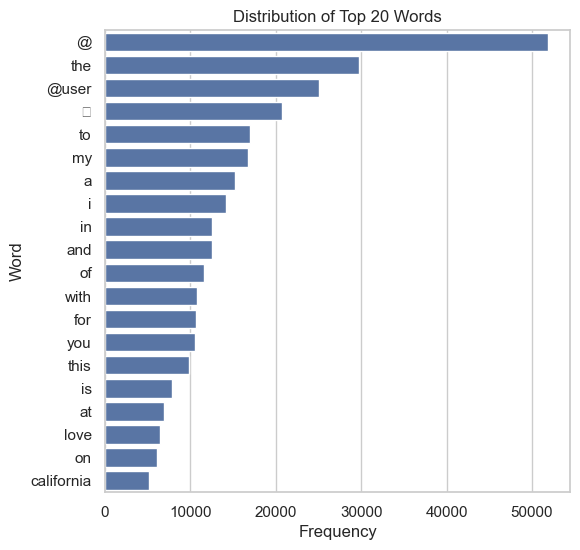

In [7]:
# plot the top words

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.title('Distribution of Top 20 Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
sns.barplot(x=[x[1] for x in top_words], y=[x[0] for x in top_words])
plt.show()

In [8]:
# Get mobilebert model

config = AutoConfig.from_pretrained('google/mobilebert-uncased')
tokenizer = AutoTokenizer.from_pretrained('google/mobilebert-uncased')

# Tokenize first tweet

tokens = tokenizer.tokenize(tweets[0])
print(tokens)

['sunday', 'afternoon', 'walking', 'through', 'venice', 'in', 'the', 'sun', 'with', '@', 'user', '@', 'abbot', 'kin', '##ney', ',', 'venice']


In [9]:
# Get the ids for the tokens
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[4465, 5027, 3788, 2083, 7914, 1999, 1996, 3103, 2007, 1030, 5310, 1030, 11428, 12631, 5420, 1010, 7914]


In [10]:
# Get the model
model = AutoModel.from_pretrained('google/mobilebert-uncased')

# Use gpu if available
model.to(device)


print(device)

cuda


In [68]:
def get_embedding_from_id(token_id):
    return model.embeddings.word_embeddings(token_id)

In [90]:
# Encode word in every tweet
# Get embeddings for every word
# Store in tensor
# Shape: (num_words, embedding_size)
# Get the ids for the tokens

# Get all words in all tweets, split on whitespace
all_tokens = []
for tweet in tweets:
    tokens = tokenizer.tokenize(tweet)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    all_tokens += token_ids

# Convert to tensor
all_tokens_tensor = torch.tensor(all_tokens)
all_tokens_tensor = all_tokens_tensor.to(device)

In [94]:
# Get embedding of first word

embedding = get_embedding_from_id(all_tokens_tensor[0])
print(embedding.shape)

torch.Size([128])


In [95]:
# Get embeddings of all tweets for dimensionality reduction
tweet_embeddings = [get_embedding_from_id(token_id) for token_id in all_tokens_tensor]

In [96]:
# Check if all embeddings are the same size
print(len(tweet_embeddings))
print(tweet_embeddings[0].shape)

for embedding in tweet_embeddings:
    assert embedding.shape == tweet_embeddings[0].shape

1918813
torch.Size([128])


In [97]:
# Convert to tensor
tweet_embeddings_tensor = torch.stack(tweet_embeddings)

# Move to cpu, for plotting
tweet_embeddings_cpu_tensor = tweet_embeddings_tensor.to('cpu')

In [ ]:
# Reduce dimensionality to 2
pca = PCA(n_components=100)
tweet_embeddings_reduced = pca.fit_transform(tweet_embeddings_cpu_tensor.detach().numpy())

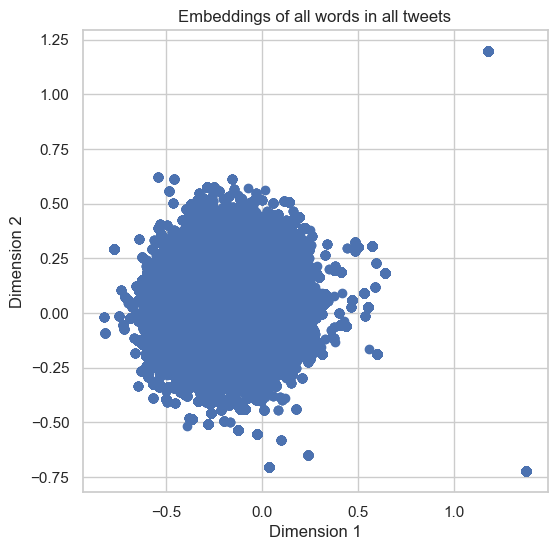

In [100]:
# Plot the embeddings
plt.figure(figsize=(6, 6))
plt.scatter(tweet_embeddings_reduced[:, 0], tweet_embeddings_reduced[:, 1])
plt.title('Embeddings of all words in all tweets')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()